# Jupyter notebooks - hands on R

In [7]:
#setwd("/home/rok/dl/github/dsm")
require(randomForest)
require(dplyr)
require(magrittr)
require(ggplot2)

## Load data and check basic properties

In [9]:
#bank <- read.csv(file="bank-full.csv",header=TRUE,sep=";", stringsAsFactors=FALSE) %>% as.tbl
bank <- read.csv(file="BankData/bank-full.csv",header=TRUE,sep=";") %>% as.tbl
bank %<>% mutate(id=1:n())

#how many with "yes" response      
bank %>% group_by(y) %>% summarise(n())


,y,n()
1,no,39922
2,yes,5289


## Split the dataset in two sets - train and test

In [10]:
trainingData <- bank %>% group_by(y) %>% sample_frac(0.1) %>% ungroup()
head(trainingData)
trainingData %<>% select(y,duration,month,contact,poutcome,pdays,day,housing)
str(trainingData)
contactModel <- nrow(trainingData)
responseTrain <- sum(trainingData$y == "yes")

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,id
1,34,technician,divorced,tertiary,no,1317,yes,no,cellular,15,may,239,1,-1,0,unknown,no,38159
2,45,entrepreneur,married,primary,no,5315,yes,yes,cellular,15,may,262,2,-1,0,unknown,no,38314
3,50,self-employed,single,tertiary,no,21,yes,no,cellular,18,nov,157,1,188,1,failure,no,25121
4,32,blue-collar,married,primary,no,274,yes,no,unknown,9,may,21,3,-1,0,unknown,no,1674
5,29,technician,married,secondary,no,-910,yes,no,cellular,21,jul,260,1,-1,0,unknown,no,15800
6,41,admin.,single,tertiary,no,982,no,no,cellular,23,jul,105,1,-1,0,unknown,no,16247


Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	4521 obs. of  8 variables:
 $ y       : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ duration: int  239 262 157 21 260 105 117 205 152 166 ...
 $ month   : Factor w/ 12 levels "apr","aug","dec",..: 9 9 10 9 6 6 10 2 11 5 ...
 $ contact : Factor w/ 3 levels "cellular","telephone",..: 1 1 1 3 1 1 2 1 1 1 ...
 $ poutcome: Factor w/ 4 levels "failure","other",..: 4 4 1 4 4 4 4 4 4 2 ...
 $ pdays   : int  -1 -1 188 -1 -1 -1 -1 -1 -1 2 ...
 $ day     : int  15 15 18 9 21 23 19 12 1 30 ...
 $ housing : Factor w/ 2 levels "no","yes": 2 2 2 2 2 1 1 2 1 1 ...


In [11]:
testData <- bank %>% filter(!id %in% trainingData$id) %>% 
    select(y,duration,month,contact,poutcome,pdays,day,housing,balance)
head(testData)

,y,duration,month,contact,poutcome,pdays,day,housing,balance
1,no,261,may,unknown,unknown,-1,5,yes,2143
2,no,151,may,unknown,unknown,-1,5,yes,29
3,no,76,may,unknown,unknown,-1,5,yes,2
4,no,92,may,unknown,unknown,-1,5,yes,1506
5,no,198,may,unknown,unknown,-1,5,no,1
6,no,139,may,unknown,unknown,-1,5,yes,231


## Train random forest model


Call:
 randomForest(formula = y ~ duration + month + contact + poutcome +      pdays + day + housing, data = trainingData, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 10.04%
Confusion matrix:
      no yes class.error
no  3888 104   0.0260521
yes  350 179   0.6616257

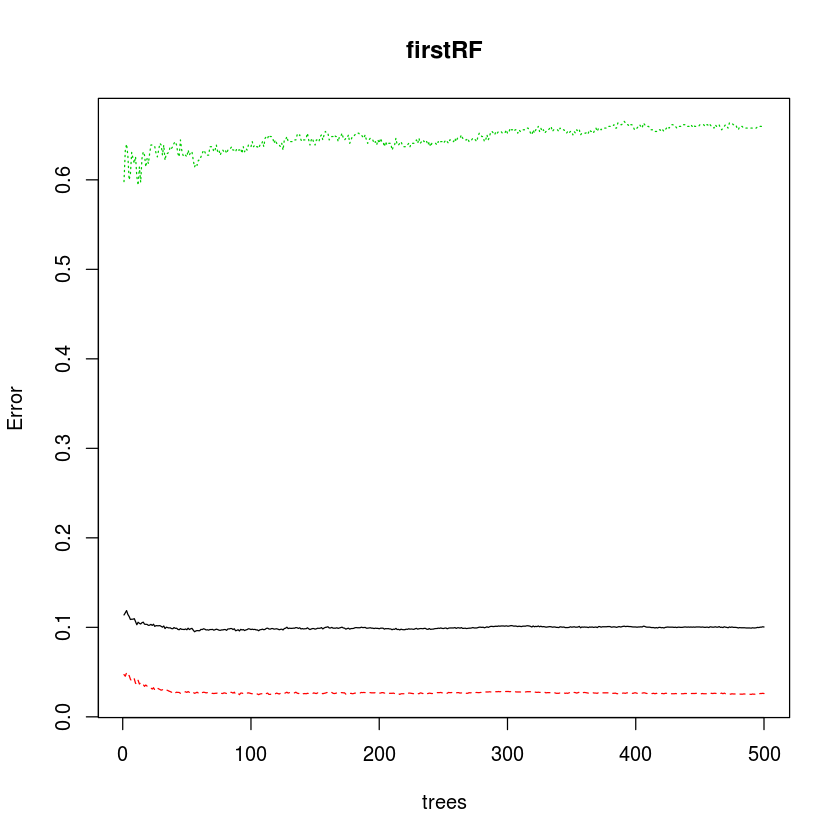

In [12]:
firstRF <- randomForest(y~duration+month+contact+poutcome+pdays+day+housing,data=trainingData,importance=TRUE)
testData %<>% mutate(predicted=predict(firstRF,.,type="prob")[,2]) %>%
	mutate(outcome=ifelse(y=="no", 0, 1))
firstRF
plot(firstRF)

## Even though the results are not very accurate, we can try to sort predictions and compare it to random and balance order

In [13]:
randomContact <- testData %>% sample_frac(1) %>% select(outcome) %>% mutate(cumSum=cumsum(outcome), group="random", orderIndex=1:n())
balanceContact <- testData %>% arrange(desc(balance)) %>% select(outcome) %>% mutate(cumSum=cumsum(outcome), group="balance", orderIndex=1:n())
predictedContact <- testData %>% arrange(desc(predicted)) %>% select(outcome) %>% mutate(cumSum=cumsum(outcome), group="predicted", orderIndex=1:n())

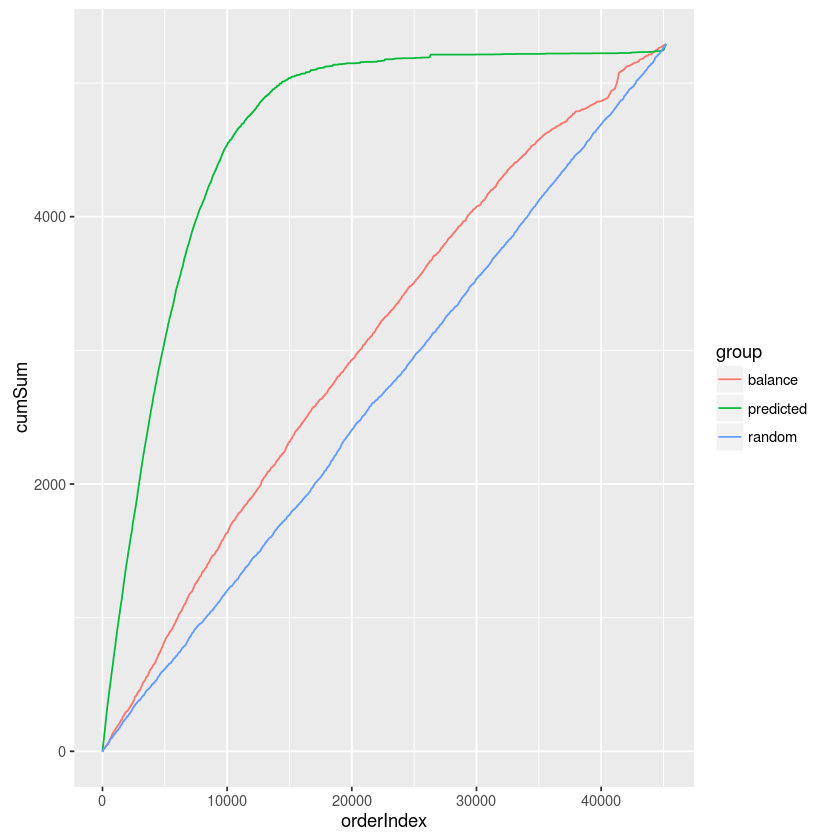

In [7]:
randomContact %>% bind_rows(predictedContact) %>% bind_rows(balanceContact) %>%
	ggplot(data=., aes(orderIndex,cumSum)) + geom_line(aes(colour=group))

In [14]:
noContact <- 12000
result <- randomContact %>% slice(noContact) %>% summarize(type="random", contacted=orderIndex, responded=cumSum) %>% 
bind_rows(balanceContact %>% slice(noContact) %>% summarize(type="balance",contacted=orderIndex, responded=cumSum)) %>%
bind_rows(predictedContact %>% slice(noContact-contactModel) %>% summarize(type="model",contacted=orderIndex+contactModel, responded=cumSum+responseTrain))

In [15]:
result %>% mutate(improvment=responded/responded[1])

,type,contacted,responded,improvment
1,random,12000,1378,1
2,balance,12000,1906,1.383164
3,model,12000,4428,3.213353
